In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''
* File       : train.ipynb
* Created    : 2023-09-19 10:51:02
* Author     : M0nk3y
* Version    : 1.0
'''
%load_ext autoreload
%autoreload 2

from dataLoder import *
from models import *
import json
from utils import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

### ASCAD N0=0 
读取JSON文件

In [2]:
with open('./model_settings.json', 'r') as f:
    settings = json.load(f)
settings = settings['ASCAD_N0']
print(settings)
globals().update(settings)

{'model_name': 'ASCAD_N0', 'batch_size': 50, 'learning_rate': 0.005, 'use_1cycle': 'True', 'input_size': 700, 'classes': 256, 'epochs': 50}


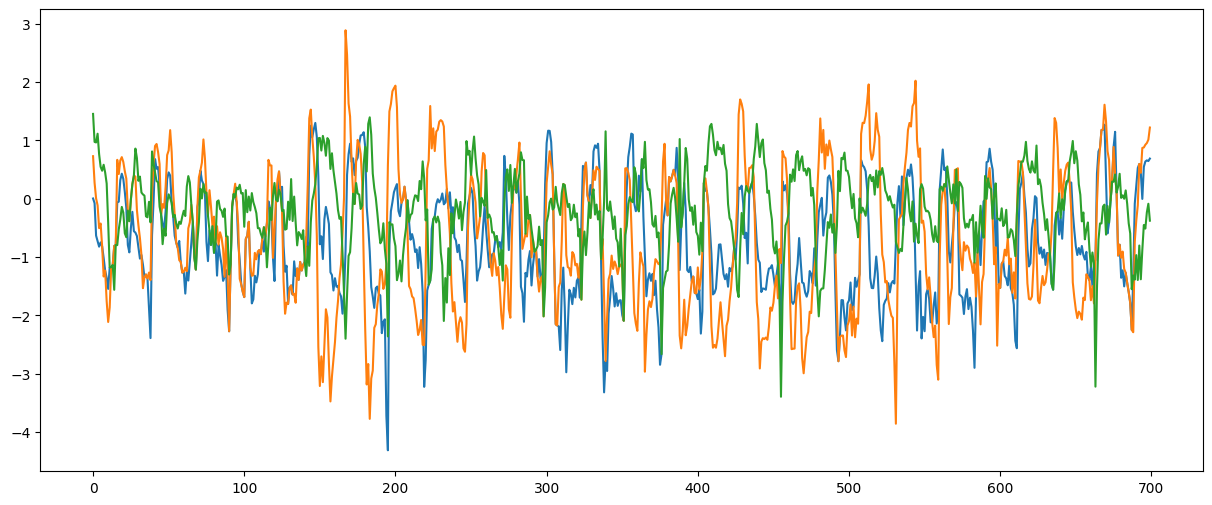

In [3]:
dataloder = DataLoder("./datasets/ASCAD_N0/ASCAD.h5")
X_profiling, Y_profiling, profiling_targets, profiling_key, X_attack, attack_targets, attack_key = dataloder.get_ascad()


# 数据预处理
X_profiling, X_attack = feature_standardization(X_profiling, X_attack)
Reshape_X_train = fit_cnn(X_profiling)
Reshape_X_attack = fit_cnn(X_attack)
# plt
fig = plt.figure(figsize=(15,6))
x = range(X_profiling.shape[1])
for i in range(3):
    plt.plot(x, X_profiling[i])

X_train, X_val, Y_train, Y_val = train_test_split(Reshape_X_train, Y_profiling, test_size=0.1)


模型配置

In [4]:
model = simple_ascad_n0(input_size=Reshape_X_train.shape[1], learning_rate=learning_rate, classes=classes)
model.summary()

Model: "simple_ascad_n0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 700, 1)]          0         
                                                                 
 block1_pool1 (AveragePoolin  (None, 350, 1)           0         
 g1D)                                                            
                                                                 
 block2_conv1 (Conv1D)       (None, 349, 32)           96        
                                                                 
 block2_pool1 (AveragePoolin  (None, 174, 32)          0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 5568)              0         
                                                                 
 fc1 (Dense)                 (None, 10)            

In [5]:

# 保存model
model_path = './models/simple_ascad_0.hdf5'
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=False)
callbacks = [checkpoint]
if use_1cycle == "True":
    lr_manager = OneCycleLR(max_lr=learning_rate, batch_size=batch_size, samples=X_profiling.shape[0], end_percentage=0.2, scale_percentage=0.1, maximum_momentum=None, minimum_momentum=None, verbose=True)
    callbacks.append(lr_manager)
history = model.fit(x=X_train, y=to_categorical(Y_train, 256), validation_data=(X_val, to_categorical(Y_val, 256)), batch_size=batch_size, verbose=1, epochs=epochs, callbacks=callbacks)

Epoch 1/50


2023-11-01 16:24:09.896668: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


888/900 [============================>.] - ETA: 0s - loss: 5.5579 - acc: 0.0036
Epoch 1: saving model to ./models/simple_ascad_0.hdf5
 - lr: 0.00072 
900/900 [==============================] - 4s 4ms/step - loss: 5.5579 - acc: 0.0035 - val_loss: 5.5476 - val_acc: 0.0048
Epoch 2/50
892/900 [============================>.] - ETA: 0s - loss: 5.5455 - acc: 0.0042
Epoch 2: saving model to ./models/simple_ascad_0.hdf5
 - lr: 0.00095 
900/900 [==============================] - 4s 4ms/step - loss: 5.5456 - acc: 0.0042 - val_loss: 5.5489 - val_acc: 0.0050
Epoch 3/50
888/900 [============================>.] - ETA: 0s - loss: 5.5432 - acc: 0.0048
Epoch 3: saving model to ./models/simple_ascad_0.hdf5
 - lr: 0.00117 
900/900 [==============================] - 3s 4ms/step - loss: 5.5433 - acc: 0.0048 - val_loss: 5.5485 - val_acc: 0.0032
Epoch 4/50
899/900 [============================>.] - ETA: 0s - loss: 5.5416 - acc: 0.0053
Epoch 4: saving model to ./models/simple_ascad_0.hdf5
 - lr: 0.00140 
900/

In [6]:
n_traces = 400
n_attack = 100
interval = 1

In [7]:
predictions = model.predict(Reshape_X_attack, verbose=1)
predictions = np.log(predictions + 1e-40)

# 计算rank
ranks = np.zeros((n_attack, int(n_traces / interval)))
for i in range(n_attack):
    ranks[i] = rank(predictions=predictions, key=attack_key, targets=attack_targets, interval=interval, num_traces=n_traces)

313/313 [==============================] - 0s 1ms/step


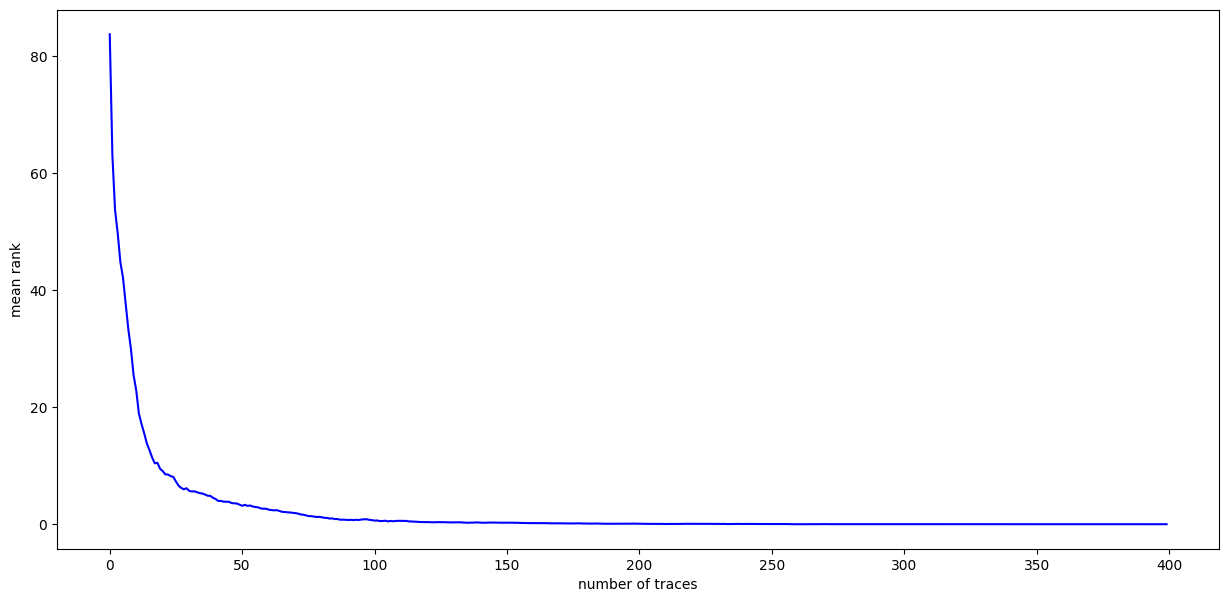

In [8]:
fig, ax = plt.subplots(figsize=(15, 7))
x = [x for x in range(0, n_traces, interval)]
ax.plot(x, np.mean(ranks, axis=0), 'b')

ax.set(xlabel="number of traces", ylabel="mean rank")
plt.show()

### ASCAD N50

读JSON文件

In [9]:
with open('./model_settings.json', 'r') as f:
    settings = json.load(f)["ASCAD_N50"]
globals().update(settings)

加载并处理数据集

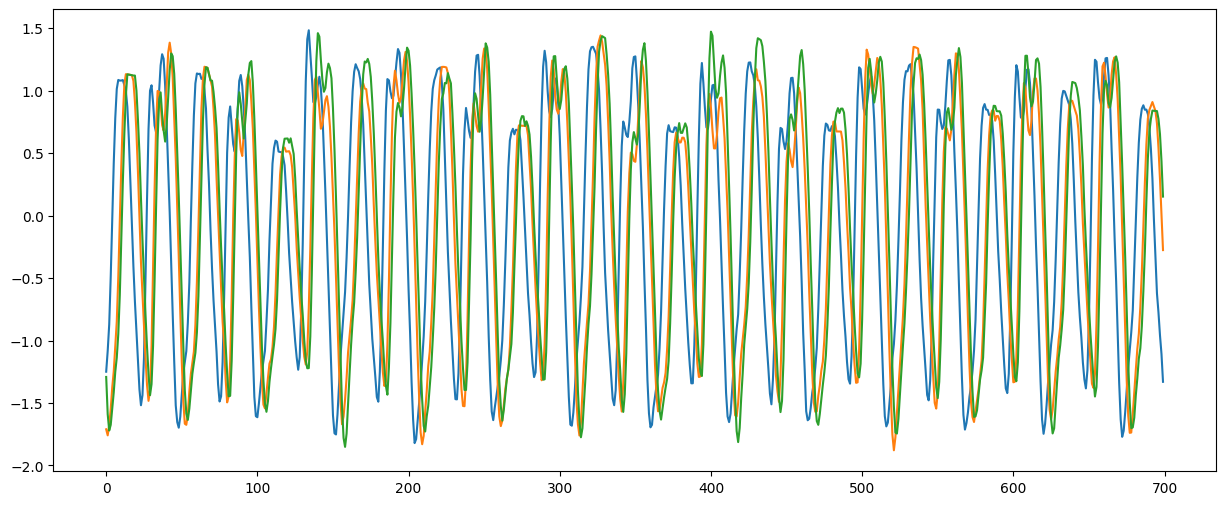

In [10]:
dataloder = DataLoder("./datasets/ASCAD_N50/ASCAD_desync50.h5")
X_profiling, Y_profiling, profiling_targets, profiling_key, X_attack, attack_targets, attack_key = dataloder.get_ascad()


# 数据预处理
X_profiling, X_attack = feature_standardization(X_profiling, X_attack)
Reshape_X_train = fit_cnn(X_profiling)
Reshape_X_attack = fit_cnn(X_attack)
# plt
fig = plt.figure(figsize=(15,6))
x = range(X_profiling.shape[1])
for i in range(3):
    plt.plot(x, X_profiling[i])

X_train, X_val, Y_train, Y_val = train_test_split(Reshape_X_train, Y_profiling, test_size=0.1)

In [11]:
model = simple_ascad_n50(X_train.shape[1], learning_rate=learning_rate, classes=classes)
model.summary()

Model: "simple_ascad_n50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 700, 1)]          0         
                                                                 
 block1_pool (AveragePooling  (None, 350, 1)           0         
 1D)                                                             
                                                                 
 block2_conv (Conv1D)        (None, 350, 64)           1664      
                                                                 
 batch_normalization (BatchN  (None, 350, 64)          256       
 ormalization)                                                   
                                                                 
 block2_pool (AveragePooling  (None, 14, 64)           0         
 1D)                                                             
                                                  

训练simple_ascad_n50

In [12]:

# 保存model
model_path = './models/simple_ascad_50.hdf5'
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=False)
callbacks = [checkpoint]
if use_1cycle == "True":
    lr_manager = OneCycleLR(max_lr=learning_rate, batch_size=batch_size, samples=X_profiling.shape[0], end_percentage=0.2, scale_percentage=0.1, maximum_momentum=None, minimum_momentum=None, verbose=True)
    callbacks.append(lr_manager)
history = model.fit(x=X_train, y=to_categorical(Y_train, 256), validation_data=(X_val, to_categorical(Y_val, 256)), batch_size=batch_size, verbose=1, epochs=epochs, callbacks=callbacks)

Epoch 1/50
897/900 [============================>.] - ETA: 0s - loss: 5.5799 - acc: 0.0039
Epoch 1: saving model to ./models/simple_ascad_50.hdf5
 - lr: 0.00072 
900/900 [==============================] - 12s 13ms/step - loss: 5.5798 - acc: 0.0039 - val_loss: 5.5605 - val_acc: 0.0034
Epoch 2/50
898/900 [============================>.] - ETA: 0s - loss: 5.5549 - acc: 0.0047
Epoch 2: saving model to ./models/simple_ascad_50.hdf5
 - lr: 0.00095 
900/900 [==============================] - 14s 15ms/step - loss: 5.5549 - acc: 0.0047 - val_loss: 5.5624 - val_acc: 0.0036
Epoch 3/50
899/900 [============================>.] - ETA: 0s - loss: 5.5486 - acc: 0.0047
Epoch 3: saving model to ./models/simple_ascad_50.hdf5
 - lr: 0.00117 
900/900 [==============================] - 13s 14ms/step - loss: 5.5487 - acc: 0.0047 - val_loss: 5.5576 - val_acc: 0.0048
Epoch 4/50
898/900 [============================>.] - ETA: 0s - loss: 5.5455 - acc: 0.0048
Epoch 4: saving model to ./models/simple_ascad_50.hdf5

In [13]:
n_traces = 400
n_attack = 100
interval = 1

In [14]:
predictions = model.predict(Reshape_X_attack, verbose=1)
predictions = np.log(predictions + 1e-40)

# 计算rank
ranks = np.zeros((n_attack, int(n_traces / interval)))
for i in range(n_attack):
    ranks[i] = rank(predictions=predictions, key=attack_key, targets=attack_targets, interval=interval, num_traces=n_traces)

313/313 [==============================] - 2s 5ms/step


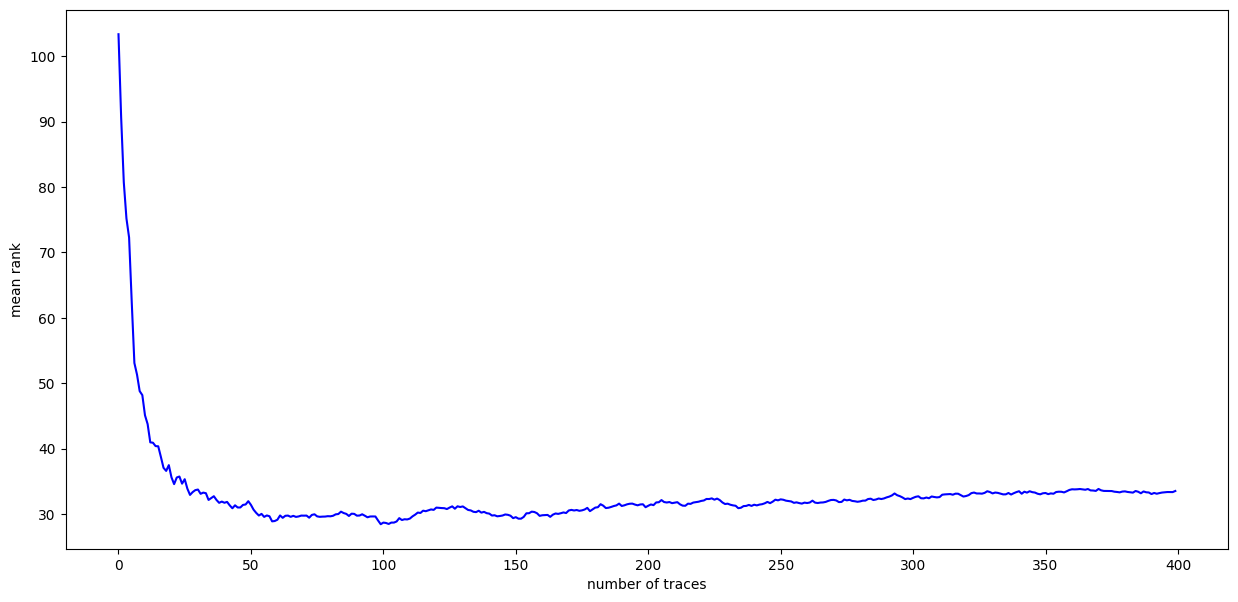

In [15]:
fig, ax = plt.subplots(figsize=(15, 7))
x = [x for x in range(0, n_traces, interval)]
ax.plot(x, np.mean(ranks, axis=0), 'b')

ax.set(xlabel="number of traces", ylabel="mean rank")
plt.show()

ASCAD_N100

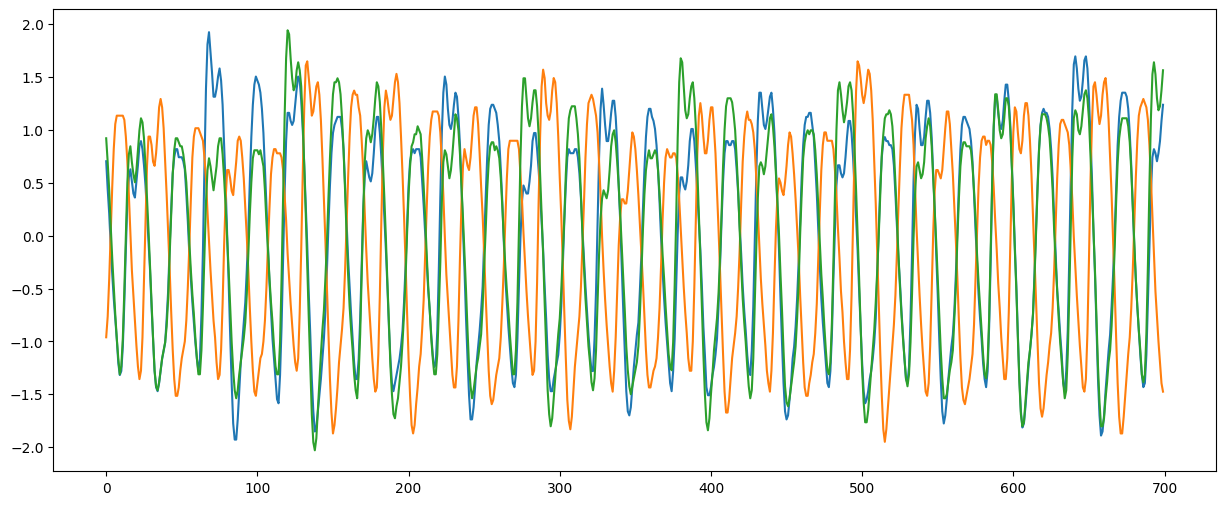

In [16]:
dataloder = DataLoder('./datasets/ASCAD_N100/ASCAD_desync100.h5')
X_profiling, Y_profiling, profiling_targets, profiling_key, X_attack, attack_targets, attack_key = dataloder.get_ascad()

X_profiling, X_attack = horizontal_standardization(X_profiling, X_attack)
Reshape_X_train = fit_cnn(X_profiling)
Reshape_X_attack = fit_cnn(X_attack)
# plt
fig = plt.figure(figsize=(15,6))
x = range(X_profiling.shape[1])
for i in range(3):
    plt.plot(x, X_profiling[i])

X_train, X_val, Y_train, Y_val = train_test_split(Reshape_X_train, Y_profiling, test_size=0.1)

In [17]:
model = simple_ascad_n100(input_size=X_train.shape[1], learning_rate=learning_rate, classes=classes)
model.summary()

Model: "simple_ascad_n100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 700, 1)]          0         
                                                                 
 block1_pool (AveragePooling  (None, 350, 1)           0         
 1D)                                                             
                                                                 
 block2_conv (Conv1D)        (None, 350, 64)           3264      
                                                                 
 batch_normalization_2 (Batc  (None, 350, 64)          256       
 hNormalization)                                                 
                                                                 
 block2_pool (AveragePooling  (None, 7, 64)            0         
 1D)                                                             
                                                 

In [18]:

# 保存model
model_path = './models/simple_ascad_100.hdf5'
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=False)
callbacks = [checkpoint]
if use_1cycle == "True":
    lr_manager = OneCycleLR(max_lr=learning_rate, batch_size=batch_size, samples=X_profiling.shape[0], end_percentage=0.2, scale_percentage=0.1, maximum_momentum=None, minimum_momentum=None, verbose=True)
    callbacks.append(lr_manager)
history = model.fit(x=X_train, y=to_categorical(Y_train, 256), validation_data=(X_val, to_categorical(Y_val, 256)), batch_size=batch_size, verbose=1, epochs=epochs, callbacks=callbacks)

Epoch 1/50
897/900 [============================>.] - ETA: 0s - loss: 5.5848 - acc: 0.0040
Epoch 1: saving model to ./models/simple_ascad_100.hdf5
 - lr: 0.00072 
900/900 [==============================] - 13s 14ms/step - loss: 5.5847 - acc: 0.0040 - val_loss: 5.5582 - val_acc: 0.0048
Epoch 2/50
897/900 [============================>.] - ETA: 0s - loss: 5.5533 - acc: 0.0043
Epoch 2: saving model to ./models/simple_ascad_100.hdf5
 - lr: 0.00095 
900/900 [==============================] - 13s 14ms/step - loss: 5.5533 - acc: 0.0043 - val_loss: 5.5572 - val_acc: 0.0026
Epoch 3/50
899/900 [============================>.] - ETA: 0s - loss: 5.5471 - acc: 0.0042
Epoch 3: saving model to ./models/simple_ascad_100.hdf5
 - lr: 0.00117 
900/900 [==============================] - 14s 16ms/step - loss: 5.5471 - acc: 0.0042 - val_loss: 5.5533 - val_acc: 0.0046
Epoch 4/50
897/900 [============================>.] - ETA: 0s - loss: 5.5458 - acc: 0.0046
Epoch 4: saving model to ./models/simple_ascad_100.

KeyboardInterrupt: 

In [ ]:
n_traces = 400
n_attack = 100
interval = 1

In [ ]:
predictions = model.predict(Reshape_X_attack, verbose=1)
predictions = np.log(predictions + 1e-40)

# 计算rank
ranks = np.zeros((n_attack, int(n_traces / interval)))
for i in range(n_attack):
    ranks[i] = rank(predictions=predictions, key=attack_key, targets=attack_targets, interval=interval, num_traces=n_traces)

313/313 [==============================] - 1s 2ms/step


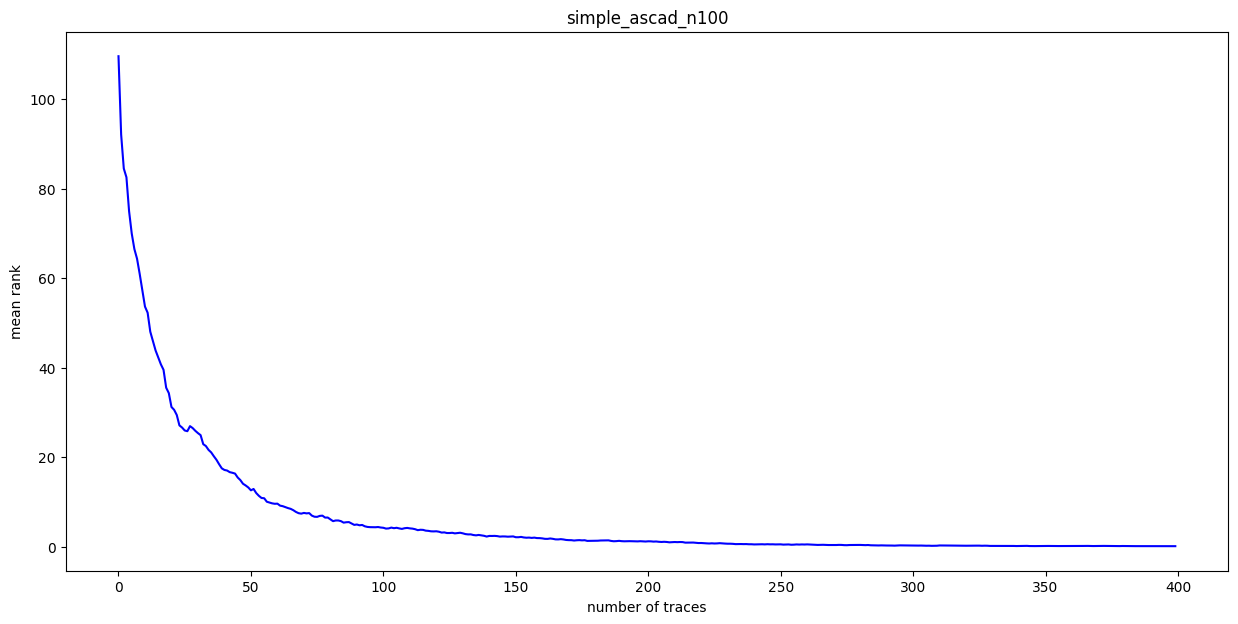

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
x = [x for x in range(0, n_traces, interval)]
ax.plot(x, np.mean(ranks, axis=0), 'b')
plt.title("simple_ascad_n100")
ax.set(xlabel="number of traces", ylabel="mean rank")
plt.show()

In [ ]:
def simple_rank(ranks):
    data = np.mean(ranks, axis=0)
    res = 0
    for i, d in enumerate(data):
        res += ((i + 1) * 0.25) * d
    return res

27276.070000000018